<a href="https://colab.research.google.com/github/uumami/workshop_riskmathics/blob/main/proyecto_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediccion de Default en Prestamos

Para este proyecto utilizaremos un sample de los datos de [Lending Club](https://www.kaggle.com/wordsforthewise/lending-club). La idea es predecir si cierto usuario cometera Default basado en informacion que la plataforma recolecta. Esto nos ayudara a mejorar la metodologia/pipeline de prestamo.  



In [2]:


# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Saving the Model
from pickle import dump
from pickle import load



# Dataset

Contiene los prestamos de esta plataforma:
+ periodo 2007-2017Q3.
+ 887mil observaciones, sample de 100mil 
+ 150 variables
+ Target: loan status

# ETL

In [21]:
loans = pd.read_csv('https://github.com/IEXE-Tec/mcda-fintech/blob/master/default_proyecto/LoansData_sample.csv.gz?raw=true', 
                    compression='gzip', encoding='utf-8')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
loans.shape

(100000, 151)

Revisemos la columna del Warning, parece que es texto, que describe el objetivo del prestamo.

In [5]:
print(loans.columns[19])
loans.loc[:,loans.columns[19]].unique()

desc


array([nan, ' ',
       'Looking to borrow to purchase a used boat we are interested in',
       'I support myself and my mother and have taken on debt to assist with her bills and health care needs. I would like to pay down debt faster through refinancing at a lower rate.',
       "Trying to pay a friend back for apartment broker's fee incurred from as well as credit card stuff."],
      dtype=object)

In [6]:
loans.shape

(100000, 151)

In [8]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(115), int64(2), object(34)
memory usage: 115.2+ MB


La primera columna parece ser un indice, podemos eliminarla.

In [14]:
type(np.nan)

float

In [26]:
dataset = loans
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
dataset['Unnamed: 0'].unique().shape

(100000,)

In [29]:
del dataset['Unnamed: 0']

Diccionario con la descripcion de los datos.

In [32]:
datos_dict = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
datos_dict.columns = ['feature', 'description']

In [33]:
datos_dict

,feature,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [56]:
datos_dict[datos_dict.feature=='total_rev_hi_lim']

,feature,description


# EDA

## Variable Target -> Default de Prestamo

In [34]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

En este caso las variables que nos interesan son los prestamos terminados, ya sea porque pagaron `Fully Paid` o porque no pagaron y el prestamo se dio por perdido `Charged Off`.  
En este caso las demas opciones, incluyendo `Default`, implican que el prestamo sigue en curso y no ha sido concluido, asi que las ignoraremos.

In [35]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 
                                                   'Charged Off'])]
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

Podemos observar que tenemos una distribucion de labels cercana al 80/20. 81% de los prestamos fueron liquidados exitosamente, mientras que el 19% nunca fue pagado.  

Creemos el label de 0 o 1 en la columna `charged_off`.

In [36]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)
dataset['charged_off'].unique()

<ipython-input-36-e4f55b937d15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([0, 1], dtype=int8)

## Feature Selection

Dada la cantidad de variables, en esta ocasion reduciremos el numero de variables antes de continuar.

Nuestra base de datos tiene 150 variables y 100 mil observaciones. Seria conveniente reducir la dimensionalidad. Sugerimos 4 criterios de **eliminacion**:
+ Baja correlacion con la variable objetivo
+ Alta correlacion entre ellas
+ Muchos Missings/NAs
+ Conocimiento del fenomeno/negocio 

### Baja correlacion con el objetivo

Una baja correlacion con el objetivo implica que explica poco.

In [ ]:
1,2,3,4

In [37]:
correlacion = dataset.corr()
correlacion_y = abs(correlacion['charged_off'])

In [38]:
correlacion_y.sort_values(ascending=False)

charged_off                                   1.000000
last_fico_range_high                          0.660562
last_fico_range_low                           0.581378
recoveries                                    0.518975
collection_recovery_fee                       0.498298
                                                ...   
hardship_length                                    NaN
orig_projected_additional_accrued_interest         NaN
settlement_amount                                  NaN
settlement_percentage                              NaN
settlement_term                                    NaN
Name: charged_off, Length: 117, dtype: float64

Los valores con NaNs es por que no tienen observaciones, las columnas estan llenas de missings.

In [42]:
dataset.shape

(86138, 150)

In [41]:
dataset.describe().shape

(8, 117)

In [39]:
correlacion_y.describe()

count    77.000000
mean      0.109109
std       0.174861
min       0.000392
25%       0.008078
50%       0.049426
75%       0.088610
max       1.000000
Name: charged_off, dtype: float64

In [46]:
drop_corr = sorted(list(correlacion_y[correlacion_y < 0.03].index))
print(f'Numero de columnas a quitar {len(drop_corr)} \n',drop_corr)

Numero de columnas a quitar 29 
 ['acc_now_delinq', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'id', 'mo_sin_old_il_acct', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'tax_liens', 'tot_coll_amt', 'total_acc', 'total_bal_ex_mort', 'total_il_high_credit_limit']


In [47]:
dataset.drop(labels=drop_corr, axis=1, inplace=True)
dataset.shape

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(86138, 121)

### Eliminacion por Missings

In [50]:
missing_per = dataset.isnull().mean().sort_values(ascending=False)
missing_per.describe()

count    121.000000
mean       0.439346
std        0.495624
min        0.000000
25%        0.000000
50%        0.000778
75%        1.000000
max        1.000000
dtype: float64

La cota de .3 es totalmente arbitraria, una buena regla de dedo para este tipo de datos es entre .25 a .5, pero puede variar mucho.

In [51]:
drop_miss = sorted(list(missing_per[missing_per > 0.3].index))
print(f'Numero de columnas a quitar {len(drop_miss)} \n',drop_miss)

Numero de columnas a quitar 53 
 ['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_rcnt_il', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlemen

In [52]:
dataset.drop(labels=drop_miss, axis=1, inplace=True)
dataset.shape

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(86138, 68)

### Conocimiento o Intuicion

Estas son algunas de las variables sugeridas por la comundiad de kaggle, sin embargo. Combiene que las revisemos nosotros manualmente.   
Tambien devemos enfocarlos en eliminar leakages, y variables que no conoceremos *a priori*. Para ello tambien nos guiamos del siguiente documento:  [Credit Risk Analysis in Peer to Peer Lending Data set: Lending Club Club](https://digitalcommons.bard.edu/cgi/viewcontent.cgi?article=1299&context=senproj_s2019). Que es muy parecido al ejercicio que estamos realizando.

In [55]:
len(dataset.columns)

68

In [53]:
print(sorted(dataset.columns))

['acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'collection_recovery_fee', 'debt_settlement_flag', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'percent_bc_gt_75', 'policy_code', 'purpose', 'pymnt_plan', 'recoveries', 'revol_util', 'sub_grade', 'term', 'title', 'tot_cur_bal', 'tot_hi_cred_li

In [54]:
elegidas = ['charged_off','funded_amnt','addr_state', 'annual_inc',
            'application_type', 'dti', 'earliest_cr_line', 'emp_length', 
            'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
            'home_ownership', 'initial_list_status', 'installment', 
            'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 
            'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
            'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 
            'total_acc', 'verification_status', 'zip_code',
            'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',
            'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal",
            "acc_open_past_24mths" ]
len(elegidas)

39

In [57]:
drop_no_intuitivas = [col for col in dataset.columns if col not in elegidas]
dataset.drop(labels=drop_no_intuitivas , axis=1, inplace=True)
dataset.shape

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(86138, 34)

## Feature Analysis & Eng

Analisemos las variables que seleccionamos mas a detalle.

Funcion Auxiliar para clasificar el tipo de variables.

In [58]:
def _check_type(value):
    ''' 
    Infiere si la variable es categorica o numerica
    apartir del tipo
    '''
    if value==object:
        return 'categorica'
    elif value==bool:
        return 'categorica' 
    elif value=='int64':
        return 'numerica'
    elif value=='float64':
        return 'numerica'

Obtengamos el tipo de cada variable

In [59]:
feature_type = pd.DataFrame(dataset.dtypes)
feature_type[0] = feature_type[0].apply(lambda x: _check_type(x))
feature_type.reset_index(inplace=True)
feature_type.rename(columns={'index':'feature',0:'tipo'},inplace=True)
feature_type.head(3)

,feature,tipo
0,loan_amnt,numerica
1,funded_amnt,numerica
2,term,categorica


### Variables Categoricas

In [61]:
features_cat = feature_type[feature_type['tipo']=='categorica']['feature']
features_cat = list(features_cat)
features_cat

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

#### Seleccion de Variables Categoricas a explorar

In [63]:
# Lista de variables categoricas a eliminar
cat_eliminar = []
dataset[features_cat].describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,86138,86138,86138,81416,81421,86138,86138,86138,86138,86138,86138,86138,86138,86138
unique,2,7,35,32987,11,4,3,13,20,846,46,598,2,1
top,36 months,C,C1,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,750xx,CA,Aug-2001,w,Individual
freq,67507,23242,5217,1576,28177,41785,34041,52968,52990,954,12571,744,43882,86138


Eliminemos `application type` pues solo tiene un valor. Es inutil para predecir.

Eliminemos `emp_title`, `zip_code` pues tienen muchos valores, y hacer one-hot encoding (dummies) aumentaria sustancialmente el numero de variables. En escencia podrian ser variables muy utilies, pero requieren de un tratamiento mas cuidadoso que es mejor dejar para otra ocasion. 

In [64]:
cat_eliminar = cat_eliminar + ['emp_title', 'zip_code', 'application_type']

In [65]:
# Para mejorar la visualizacion de las variables categoricas que nos quedan
# por analizar
features_cat = [f for f in features_cat if f not in cat_eliminar]
dataset[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,initial_list_status
count,86138,86138,86138,81421,86138,86138,86138,86138,86138,86138,86138
unique,2,7,35,11,4,3,13,20,46,598,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,CA,Aug-2001,w
freq,67507,23242,5217,28177,41785,34041,52968,52990,12571,744,43882


+ `term`:  "The number of payments on the loan. Values are in months and can be either 36 or 60. The 60 Months loans are more likelely to charge off."   
Es la duracion del prestamo, facilmente podemos convertirla a dummy, pues toma solo dos valores.

+ `purpose` y `title` que por la descripcion parecen tener valores similares.

In [66]:
dataset[['title', 'purpose']].drop_duplicates()

,title,purpose
0,Debt consolidation,debt_consolidation
1,Credit card refinancing,credit_card
6,Home improvement,home_improvement
11,Home buying,house
16,Medical expenses,medical
...,...,...
82765,Other,home_improvement
94706,Home buying,credit_card
95664,mlue,debt_consolidation
97405,Other,vacation


+ `title` se parece a `purpose`, pero con menos valores, ademas de parecer mas certero. Elijamos `purpose` para mantener un modelo parsimonioso.

In [67]:
cat_eliminar = cat_eliminar + ['title']
# Para facilitar la visualizacion
features_cat = [f for f in features_cat if f not in cat_eliminar]
dataset[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status
count,86138,86138,86138,81421,86138,86138,86138,86138,86138,86138
unique,2,7,35,11,4,3,13,46,598,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,CA,Aug-2001,w
freq,67507,23242,5217,28177,41785,34041,52968,12571,744,43882


+ `grade` y `sub_grade`son muy parecidas. Intuitivamente sabemos que subgrade contiene a grade, y que son variables muy importantes. Por lo anterior, lo conveniente seria analizar el poder explicativo de cada una y decidir. 
Ademas, dada la naturaleza de la variable incluso podrias convertirla en numerica sin perder mucho poder explicativo, siempre y cuando este bien construida de inicio.

In [70]:
dataset[['grade', 'sub_grade']].drop_duplicates()

,grade,sub_grade
0,C,C1
1,A,A3
2,D,D1
4,C,C3
6,B,B5
7,B,B4
8,C,C4
11,D,D5
14,B,B3
15,C,C5


+ Intuitivamente `emp_length` parece una variable categorica importante, y facil de convertir a valor numerico sin perder poder explicativo. 

In [71]:
dataset['emp_length'].unique()

array(['10+ years', '8 years', '6 years', '< 1 year', '2 years',
       '9 years', '7 years', '3 years', '1 year', nan, '4 years',
       '5 years'], dtype=object)

+ `home_ownership` y `verification_status` parecen ser buenas variables de inicio, y no tienen tantos valores unicos. Son aptas para hacer one-hot encoding.

In [72]:
dataset['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [73]:
dataset['verification_status'].unique()

array(['Source Verified', 'Not Verified', 'Verified'], dtype=object)

+ `initial_list_status` no esta claro que significa, sin embargo no hay evidencia para eliminarla, por ahora. Pero, debemos de estar seguros que conoceremos el valor de esta variable antes de incluirla, pues seria inservible y arruinaria nuestro modelo.

In [ ]:
datos_dict[datos_dict['feature'] == 'initial_list_status'].values

array([['initial_list_status',
        'The initial listing status of the loan. Possible values are – W, F']],
      dtype=object)

In [74]:
dataset['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

+ `earliest_cr_line` es otra variable que podemos convertir en numerica o simplificarla sin perder mucho poder predictivo.

In [ ]:
dataset['earliest_cr_line'].unique()

array(['Aug-1994', 'Sep-1989', 'Aug-2003', 'Aug-2002', 'Nov-1992',
       'Oct-2001', 'Nov-2003', 'Oct-1998', 'May-2009', 'Jul-2003',
       'Jan-1999', 'Jan-2001', 'Jul-1989', 'Sep-1996', 'Jun-1995',
       'Dec-1993', 'Feb-2010', 'Jan-2002', 'Jun-2001', 'Nov-1998',
       'Apr-2007', 'Mar-2003', 'Mar-2002', 'Jul-2001', 'Oct-2000',
       'Jan-2003', 'Jul-2007', 'Sep-1981', 'Mar-1992', 'Mar-2011',
       'Jul-2002', 'Mar-1995', 'Jan-1981', 'Mar-1999', 'Aug-2008',
       'May-2007', 'Aug-2006', 'Jun-1996', 'Jun-2004', 'Aug-1989',
       'Feb-1997', 'Oct-2010', 'Mar-1982', 'Oct-1993', 'Aug-2004',
       'Aug-1996', 'Apr-1987', 'Dec-1988', 'Mar-2004', 'Feb-1994',
       'Jul-1996', 'Apr-1993', 'Mar-2000', 'May-2004', 'Apr-2003',
       'May-1993', 'Jul-2005', 'Sep-1987', 'Sep-2001', 'Nov-1989',
       'Dec-2009', 'Oct-1991', 'Oct-1970', 'Nov-1988', 'Dec-2001',
       'Dec-1999', 'Dec-2006', 'Sep-1985', 'Dec-2000', 'Aug-2010',
       'Jun-2009', 'Oct-2005', 'Oct-1989', 'Dec-1986', 'Apr-19

+ Por ultimo queda `addr_state` que si bien podria tener algo de poder explicativo, toma muchos valores. Es dificil convertirla en numerica o reducir su dimensionalidad. Sera para otra ocasion

In [76]:
cat_eliminar = cat_eliminar + ['addr_state']

Ahora que hemos elegido las variables categoricas que posiblemnte nos sirvan, hay que analizarlas a detalle despues de transformarlas.

In [77]:
features_cat = [f for f in features_cat if f not in cat_eliminar]
dataset[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,earliest_cr_line,initial_list_status
count,86138,86138,86138,81421,86138,86138,86138,86138,86138
unique,2,7,35,11,4,3,13,598,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,Aug-2001,w
freq,67507,23242,5217,28177,41785,34041,52968,744,43882


In [78]:
dataset.drop(cat_eliminar, axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Analisis de Variables Categoricas Seleccionadas

In [79]:
features_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'initial_list_status']

###### term

**term**: "The number of payments on the loan. Values are in months and can be either 36 or 60. The 60 Months loans are more likelely to charge off."
+ Podemos convertirla a variable numerica sin problema.

In [80]:
dataset['term'].unique()

array([' 60 months', ' 36 months'], dtype=object)

In [81]:
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

<ipython-input-81-07f3b21acd03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))


In [82]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Podemos observar que el default o `charge_off` es doblemente probable cuando el periodo de prestamo son 60 meses comparado con el de 30.

###### emp_length

**emp_length**: Es el tiempo que lleva en su ultimo empleo. Podemos convertirla a numerica.

In [83]:
dataset['emp_length'].unique()

array(['10+ years', '8 years', '6 years', '< 1 year', '2 years',
       '9 years', '7 years', '3 years', '1 year', nan, '4 years',
       '5 years'], dtype=object)

In [84]:
def emp_length_to_int(s):
    '''Variable auxiliar de limpieza de emp_length '''
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [85]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
<ipython-input-85-6263b1bf8d2a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)


In [86]:
charge_off_rates = dataset.groupby(
    'emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates

emp_length
0.0     0.200567
1.0     0.190259
2.0     0.179634
3.0     0.184257
4.0     0.175262
5.0     0.172605
6.0     0.188642
7.0     0.185727
8.0     0.191016
9.0     0.190933
10.0    0.181921
Name: charged_off, dtype: float64

In [87]:
dataset[['emp_length','charged_off']].corr()

,emp_length,charged_off
emp_length,1.000000,-0.005975
charged_off,-0.005975,1.000000


Podemos observar que esta variable no tiene mucho poder explicativo. La proporcion es parecida para cada valor, y parece no estar correlacionada con el target. En este caso los datos no soportan nuestra intuicion, hay que eliminarla.

In [88]:
dataset.drop(['emp_length'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


###### sub_grade

<AxesSubplot:xlabel='sub_grade'>

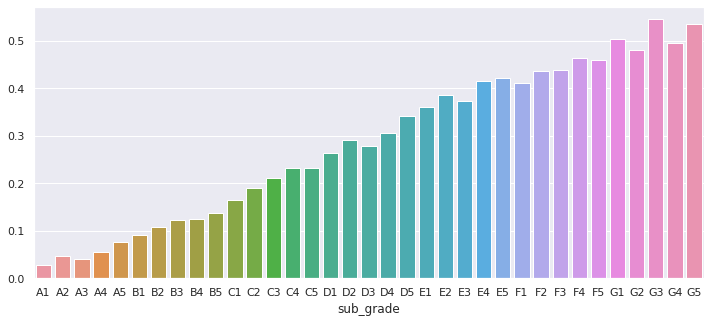

In [89]:
charge_off_rates = dataset.groupby('sub_grade'
            )['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values)

Podemos observar que la probabilidad de incurrir en `charge_off` aumenta conforme el `sub_grade` decrece. En este caso los datos favorecen nuestra intuicion.

Dado que observamos un comportamiento monotono-decreciente que sigue cierta logica (mejor score menor probabilidad de fallo) podemos convertirla en variable numerica.

In [90]:
# Este es un encoder de labels no de Xs, sin embargo lo usaremos.
from sklearn.preprocessing import LabelEncoder
label_f = LabelEncoder()
dataset['sub_grade'] = label_f.fit_transform(dataset['sub_grade'])

<ipython-input-90-d4f2d0d127c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sub_grade'] = label_f.fit_transform(dataset['sub_grade'])


<AxesSubplot:xlabel='sub_grade'>

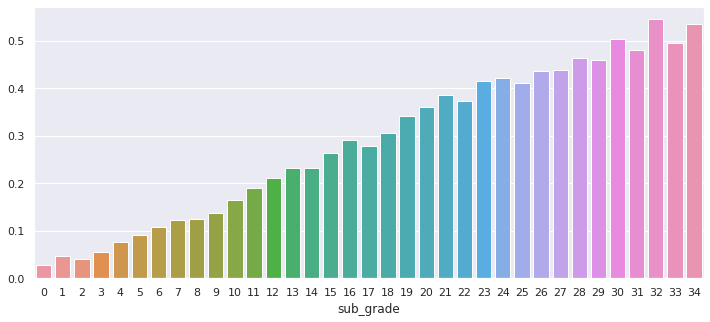

In [91]:
charge_off_rates = dataset.groupby('sub_grade'
            )['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values)

Ahora podemos eliminar `grade`, pues logramos usar una variable mas granular.

In [92]:
dataset[['sub_grade', 'charged_off']].corr()

,sub_grade,charged_off
sub_grade,1.000000,0.284397
charged_off,0.284397,1.000000


In [93]:
dataset.drop(['grade'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


###### home_ownership

In [94]:
dataset['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [95]:
charge_off_rates = dataset.groupby(
    'home_ownership')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates

home_ownership
MORTGAGE    0.166040
OWN         0.188597
RENT        0.212734
Name: charged_off, dtype: float64

In [96]:
dataset[dataset['home_ownership']=='ANY']

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
80625,5000.0,5000.0,36,11.67,165.29,8,ANY,35680.0,Source Verified,debt_consolidation,...,5048.63,5.0,18703.0,4381.0,43.1,92.0,3.0,1.0,3.0,0


Observamos como el valor `ANY` solo aprece una vez, es mejor eliminarlo.

In [97]:
dataset = dataset[dataset['home_ownership']!='ANY']

In [98]:
pd.get_dummies(dataset[['home_ownership', 'charged_off']], columns=['home_ownership'], 
               drop_first=True).corr()

,charged_off,home_ownership_OWN,home_ownership_RENT
charged_off,1.000000,0.000906,0.053804
home_ownership_OWN,0.000906,1.000000,-0.284968
home_ownership_RENT,0.053804,-0.284968,1.000000


Observemos como `home_ownership_OWN` tiene una correlacion muy baja con el objetivo. Para ser parsimoniosos podemos quitarlas.

In [99]:
dataset = pd.get_dummies(dataset, columns=['home_ownership'], 
               drop_first=True)
dataset.drop(['home_ownership_OWN'], axis=1, inplace=True)

###### verification_status

In [100]:
pd.get_dummies(dataset[['verification_status', 'charged_off']], columns=['verification_status'], 
               drop_first=True).corr()

,charged_off,verification_status_Source Verified,verification_status_Verified
charged_off,1.000000,0.046500,0.061649
verification_status_Source Verified,0.046500,1.000000,-0.494319
verification_status_Verified,0.061649,-0.494319,1.000000


In [101]:
dataset = pd.get_dummies(dataset, columns=['verification_status'], 
               drop_first=True)

###### 'purpose'

In [102]:
dataset['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'home_improvement', 'house',
       'medical', 'other', 'car', 'major_purchase', 'moving',
       'small_business', 'vacation', 'renewable_energy', 'wedding'],
      dtype=object)

In [103]:
pd.get_dummies(dataset[['purpose', 'charged_off']], columns=['purpose'], 
               drop_first=True).corr()

,charged_off,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
charged_off,1.000000,-0.037444,0.030523,-0.011345,0.006606,-0.000305,0.003501,0.014111,0.000302,0.006544,0.026016,-0.003054,-0.002836
purpose_credit_card,-0.037444,1.000000,-0.673695,-0.124168,-0.030663,-0.070974,-0.054659,-0.044651,-0.123339,-0.014537,-0.050666,-0.038635,-0.003146
purpose_debt_consolidation,0.030523,-0.673695,1.000000,-0.294310,-0.072679,-0.168227,-0.129557,-0.105835,-0.292345,-0.034458,-0.120092,-0.091575,-0.007458
purpose_home_improvement,-0.011345,-0.124168,-0.294310,1.000000,-0.013395,-0.031006,-0.023878,-0.019506,-0.053882,-0.006351,-0.022134,-0.016878,-0.001375
purpose_house,0.006606,-0.030663,-0.072679,-0.013395,1.000000,-0.007657,-0.005897,-0.004817,-0.013306,-0.001568,-0.005466,-0.004168,-0.000339
purpose_major_purchase,-0.000305,-0.070974,-0.168227,-0.031006,-0.007657,1.000000,-0.013649,-0.011150,-0.030799,-0.003630,-0.012652,-0.009647,-0.000786
purpose_medical,0.003501,-0.054659,-0.129557,-0.023878,-0.005897,-0.013649,1.000000,-0.008587,-0.023719,-0.002796,-0.009743,-0.007430,-0.000605
purpose_moving,0.014111,-0.044651,-0.105835,-0.019506,-0.004817,-0.011150,-0.008587,1.000000,-0.019376,-0.002284,-0.007959,-0.006069,-0.000494
purpose_other,0.000302,-0.123339,-0.292345,-0.053882,-0.013306,-0.030799,-0.023719,-0.019376,1.000000,-0.006308,-0.021986,-0.016765,-0.001365
purpose_renewable_energy,0.006544,-0.014537,-0.034458,-0.006351,-0.001568,-0.003630,-0.002796,-0.002284,-0.006308,1.000000,-0.002591,-0.001976,-0.000161


En este caso casi todas las correlaciones son muy bajas, solo `purpose_credit_card` y `purpose_debt_consolidation` parecen ser utiles.  
Tambien se podrian colapsar variables, pero eso es recomendable para otra iteracion.

In [104]:
dummies_purpose = pd.get_dummies(dataset[['purpose', 'charged_off']], columns=['purpose'], 
               drop_first=True).corr().index
dummies_purpose = [v for v in dummies_purpose if v not in ['charged_off', 
                                                           'purpose_credit_card',
                                                           'purpose_debt_consolidation'
                                                           ]]
dataset = pd.get_dummies(dataset, columns=['purpose'], 
               drop_first=True) 
dataset.drop(dummies_purpose, axis=1, inplace=True)                                                  

###### earliest_cr_line

In [105]:
dataset['earliest_cr_line'].head(3)

0    Aug-1994
1    Sep-1989
2    Aug-2003
Name: earliest_cr_line, dtype: object

In [106]:
# Convirtamos sus valores a numerico
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda x: int(x[4:]))

In [107]:
dataset[['earliest_cr_line', 'charged_off']].corr()

,earliest_cr_line,charged_off
earliest_cr_line,1.000000,0.039028
charged_off,0.039028,1.000000


La correlacion no es la mejor, pero podemos dejarla.

###### initial_list_status

In [108]:
dataset['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [109]:
pd.get_dummies(dataset[['initial_list_status', 'charged_off']], 
               columns=['initial_list_status'], 
               drop_first=True).corr()

,charged_off,initial_list_status_w
charged_off,1.000000,0.042561
initial_list_status_w,0.042561,1.000000


La correlacion no es tan buena, pero podemos dejarla.

In [110]:
dataset = pd.get_dummies(dataset, 
               columns=['initial_list_status'], 
               drop_first=True)

#### Aprendizaje

Ahora hemos terminado de convertir nuestras variables categoricas a numericas, de tal forma que nuestros algoritmos podran leerlas. Pasaremos a analizarlas en conjunto con nuestras variables numericas.

### Seleccion de Features Numericas

#### Feature with Feature Correlation

Eliminemos las variables explicativas que esten muy relacioandas entre si. La idea es que es informacion redundante.

In [111]:
feature_correlation = dataset.loc[:, dataset.columns != 'charged_off'].corr()
feature_correlation

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,annual_inc,dti,earliest_cr_line,fico_range_low,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,initial_list_status_w
loan_amnt,1.000000,1.000000,0.367128,0.081989,0.956719,0.085489,0.375334,0.004032,-0.170876,0.145435,...,0.179364,0.055015,0.241954,0.153569,-0.185336,0.124784,0.245929,0.040756,0.086807,0.108390
funded_amnt,1.000000,1.000000,0.367128,0.081989,0.956719,0.085489,0.375334,0.004032,-0.170876,0.145435,...,0.179364,0.055015,0.241954,0.153569,-0.185336,0.124784,0.245929,0.040756,0.086807,0.108390
term,0.367128,0.367128,1.000000,0.412062,0.128710,0.415738,0.047923,0.071772,-0.024371,-0.000104,...,0.024166,-0.009404,0.099086,0.049406,-0.092168,0.142710,0.080076,-0.037796,0.077619,0.290630
int_rate,0.081989,0.081989,0.412062,1.000000,0.078194,0.996177,-0.116061,0.203281,0.135407,-0.387205,...,-0.153263,-0.124426,-0.078239,0.082477,0.069182,0.034614,0.205737,-0.214897,0.088257,0.028108
installment,0.956719,0.956719,0.128710,0.078194,1.000000,0.080507,0.368545,0.005830,-0.156109,0.105185,...,0.163315,0.044395,0.214367,0.159329,-0.160240,0.097286,0.254309,0.029269,0.084410,0.028257
sub_grade,0.085489,0.085489,0.415738,0.996177,0.080507,1.000000,-0.114916,0.203937,0.135370,-0.385240,...,-0.152921,-0.123908,-0.077277,0.081448,0.068081,0.035448,0.207645,-0.215312,0.087888,0.029894
annual_inc,0.375334,0.375334,0.047923,-0.116061,0.368545,-0.114916,1.000000,-0.211709,-0.162855,0.103122,...,0.159430,0.043774,0.252861,0.072760,-0.156225,0.027402,0.073827,-0.002254,-0.020281,0.017401
dti,0.004032,0.004032,0.071772,0.203281,0.005830,0.203937,-0.211709,1.000000,-0.027557,-0.065502,...,0.029656,-0.023141,-0.068518,0.255069,-0.000791,0.049590,0.045077,-0.013306,0.082383,0.005675
earliest_cr_line,-0.170876,-0.170876,-0.024371,0.135407,-0.156109,0.135370,-0.162855,-0.027557,1.000000,-0.100665,...,-0.923234,-0.052819,-0.298256,-0.147584,0.214746,0.006317,-0.097256,-0.003730,-0.008860,-0.022950
fico_range_low,0.145435,0.145435,-0.000104,-0.387205,0.105185,-0.385240,0.103122,-0.065502,-0.100665,1.000000,...,0.116309,0.103099,0.089885,-0.156617,-0.128729,-0.030043,-0.021060,0.002703,-0.033653,0.040094


<AxesSubplot:>

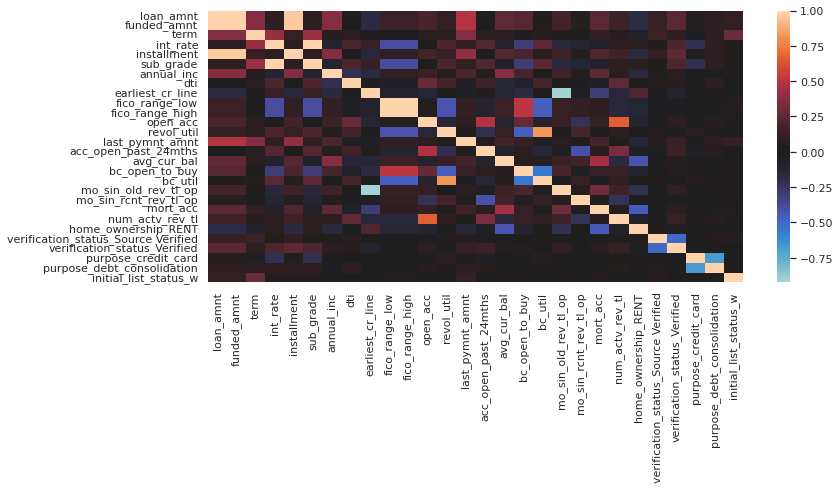

In [112]:
sns.heatmap(feature_correlation, 
        xticklabels=feature_correlation.columns,
        yticklabels=feature_correlation.columns, center=0)

In [114]:
# Solo usaremos la matriz triangular
# Recuerda que la matriz de correlacion es simetrica
upper = feature_correlation.where(np.triu(np.ones(
    feature_correlation.shape), k=1).astype(np.bool))

# Encuentra variables con correlacion mayor a threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

to_drop

<ipython-input-114-ce85a8e605ad>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feature_correlation.shape), k=1).astype(np.bool))


['funded_amnt', 'installment', 'sub_grade', 'fico_range_high']

In [115]:
# Eliminar columnas 
dataset.drop(to_drop, axis=1, inplace=True)

<AxesSubplot:>

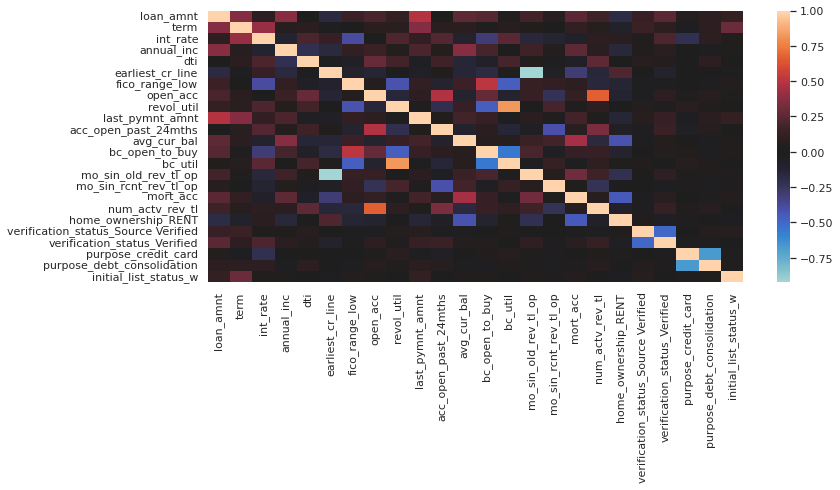

In [116]:
feature_correlation = dataset.loc[:, dataset.columns != 'charged_off'].corr()
sns.heatmap(feature_correlation, 
        xticklabels=feature_correlation.columns,
        yticklabels=feature_correlation.columns, center=0)

In [117]:
from scipy.stats import mode
df = pd.DataFrame({'mode_control':['b','b','b','c','a','a','a'], 
                   'iden':list(range(0,7)), 'rand':np.random.rand(7)})
# df = pd.DataFrame({'mode_control':[3,3,3,5,2,2,2], 
#                    'iden':list(range(0,7)), 'rand':np.random.rand(7)})
mode(df['mode_control'])

ModeResult(mode=array(['a'], dtype=object), count=array([3]))

In [118]:
df.value_counts

<bound method DataFrame.value_counts of   mode_control  iden      rand
0            b     0  0.051332
1            b     1  0.471232
2            b     2  0.582164
3            c     3  0.266478
4            a     4  0.177601
5            a     5  0.769163
6            a     6  0.008328>

In [119]:
def mode1(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return m

In [120]:
from collections import Counter
from itertools import groupby

l = df['mode_control']
# group most_common output by frequency
freqs = groupby(Counter(l).most_common(), lambda x:x[1])
# pick off the first group (highest frequency)
print([val for val,count in next(freqs)[1]])

['b', 'a']


In [121]:
df.sample(axis='columns').columns[0]

'iden'

# Modelaje

**Nota**: Para conducir los procesos anteriores no dividimos train y test, por lo que existe **leakage** en nuestro modelo. Sin embargo, dado que este es un subsample (150K) de la base completa (887K) no hay tanto problema pues tenemos muchas observaciones para hacer validacion.  

Sin embargo, cualquier division que hagamos de los datos que ya analizamos tendra leakage. Por ejemplo, vamos a subestimar el error, pues usamos correlacion con la varaible objetivo para elegir variables.  

Normalemente se hacen analisis de esta manera si sabemos que tendremos mucho mas datos nuevos. Aunque, en estricto sentido esta mal, pero nos ayuda a ahorrarnos tiempo y hacer el codigo mas sencillo. Pues no tenemos que manejar diferentes bases.  

Lo correcto es al acabar este analisis, es optimizar/refactor el codigo que tenemos y entonces si hacer un analisis con lo aprendido y con los datos divididos desde el inicio.

## (sub) Sampleo de Datos

Dado que tenemos clases desbalanceadas podemos realizar subsampling (reduccion) de la clase con mas etiquetas, o oversampling (aumento) de la clase con menos etiquetas.  Para la clase realizaremos, subsampling. De **tarea** realiza oversampling (seccion de abajo).

In [123]:
df = dataset.copy()

In [124]:
df.rename(columns={'charged_off':'y'}, inplace=True)

In [125]:
df['y'].value_counts()

0    69981
1    16156
Name: y, dtype: int64

In [126]:
df.shape

(86137, 25)

In [127]:
df.head()

,loan_amnt,term,int_rate,annual_inc,dti,earliest_cr_line,fico_range_low,open_acc,revol_util,last_pymnt_amnt,...,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,y,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,initial_list_status_w
0,15000.0,60,12.39,78000.0,12.03,1994,750.0,6.0,29.0,12017.81,...,1.0,0.0,4.0,0,1,1,0,0,1,1
1,10400.0,36,6.99,58000.0,14.92,1989,710.0,17.0,31.6,321.08,...,1.0,1.0,9.0,1,0,0,0,1,0,1
2,21425.0,60,15.59,63800.0,18.49,2003,685.0,10.0,76.2,17813.19,...,7.0,0.0,4.0,0,1,1,0,1,0,1
4,7650.0,36,13.66,50000.0,34.81,2002,685.0,11.0,91.9,17.70,...,8.0,0.0,4.0,1,1,1,0,0,1,0
5,9600.0,36,13.66,69000.0,25.81,1992,680.0,12.0,59.4,9338.58,...,23.0,0.0,7.0,0,1,1,0,0,1,0


In [128]:
default_0 = df[df['y']==0]
default_1 = df[df['y']==1]
# Subsample default_0
default_0 = default_0.sample(n=default_1.shape[0], random_state=152, 
                             replace=False)
# Merge datasets
df = pd.concat([default_1, default_0],ignore_index=True)
df = df.sample(frac=1.0).reset_index(drop=True)
df['y'].value_counts()

0    16156
1    16156
Name: y, dtype: int64

## (over) Sampleo de Datos

La siguiente celda contiene el codigo de oversampling.  
+ Piensa si el oversampling de datos deberia hacerse despues o antes de train/test, o de laguna otra forma?

In [130]:
##TODO: Tarea

# default_0 = df[df['y']==0]
# default_1 = df[df['y']==1]
# # Subsample default_0
# default_1 = default_1.sample(n=default_0.shape[0], random_state=192, 
#                              replace=True)
# # Merge datasets
# df = pd.concat([default_1, default_0],ignore_index=True)
# df = df.sample(frac=1.0).reset_index(drop=True)
# df['y'].value_counts()

### Imputacion de Datos

In [131]:
#Filling the NAs with the mean of the column.
df.fillna(df.mean(),inplace = True)

## Train/Test Split

In [132]:
Y= df["y"]
X = df.loc[:, df.columns != 'y']
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, 
                                                test_size=validation_size,
                                                 random_state=984)



## Normalizacion

In [136]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_validation = mm_scaler.transform(X_validation)

## Modelos

In [139]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(max_iter=500)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier(max_iter=500, solver='sgd', 
                                   early_stopping=True)))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

# Metricas
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'


# ##Opciones
seed = 7364
num_folds = 5


### Entrenamiento

In [140]:
results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold,
                                 scoring=scoring, n_jobs=-1)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    cv_results = pd.DataFrame({
        'results':cv_results
    })
    cv_results.loc[:,'model_name'] = name
    results.append(cv_results)

# Convertir todos los resultados un solo DataFrame
results = pd.concat(results, ignore_index=True)

LR: 0.920513 (0.003239)
LDA: 0.901031 (0.004420)
KNN: 0.820080 (0.005031)
CART: 0.806447 (0.004999)
NB: 0.896346 (0.005028)
NN: 0.912354 (0.003662)
AB: 0.931544 (0.002320)
GBM: 0.940282 (0.002126)
RF: 0.932924 (0.002802)
ET: 0.923583 (0.004091)


### Comparacion

<AxesSubplot:xlabel='model_name', ylabel='results'>

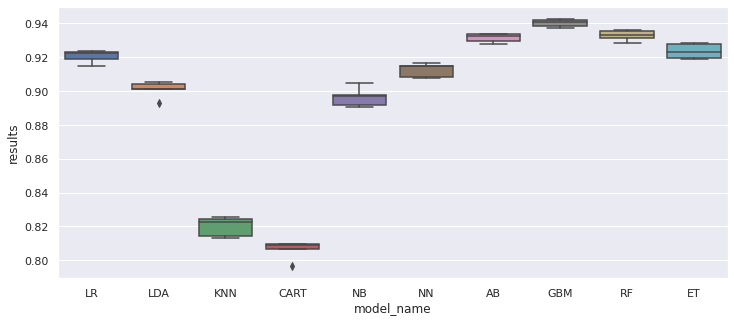

In [141]:
# compare algorithms
sns.boxplot(data=results, x='model_name', y ='results')

## GBM

In [142]:
# Grid Search: GradientBoosting 
'''
n_estimators : int (default=100)
    Numero de boostings que realiza. Es bastante robusto a overfitting,
    en comparacion con otros algoritmos de boosting. Por lo que, podemos usar
    un numero grande.
max_depth : integer, optional (default=3)
    El depth o profundida de los estimadores individuales. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; 
    the best value depends on the interaction of the input variables.

''' 
n_estimators = [50, 100, 150,180]
max_depth= [5, 7]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

model = GradientBoostingClassifier()
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring,
                          cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Mejor: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Mejor: 0.941369 using {'max_depth': 5, 'n_estimators': 100}
#5 0.940291 (0.001823) with: {'max_depth': 5, 'n_estimators': 50}
#1 0.941369 (0.001813) with: {'max_depth': 5, 'n_estimators': 100}
#2 0.941230 (0.001627) with: {'max_depth': 5, 'n_estimators': 150}
#4 0.940872 (0.001768) with: {'max_depth': 5, 'n_estimators': 180}
#8 0.939633 (0.002381) with: {'max_depth': 7, 'n_estimators': 50}
#3 0.940934 (0.002295) with: {'max_depth': 7, 'n_estimators': 100}
#6 0.940125 (0.002702) with: {'max_depth': 7, 'n_estimators': 150}
#7 0.940003 (0.002362) with: {'max_depth': 7, 'n_estimators': 180}


In [143]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.380579,0.248916,0.011968,0.001689,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.941353,0.937895,0.938268,0.941912,0.942030,0.940291,0.001823,5
1,16.853966,0.982311,0.015881,0.000687,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.941912,0.939332,0.939137,0.943051,0.943411,0.941369,0.001813,1
2,21.999150,0.657907,0.024515,0.007994,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.941574,0.939877,0.938876,0.942705,0.943119,0.941230,0.001627,2
3,28.603230,0.957992,0.026537,0.004488,5,180,"{'max_depth': 5, 'n_estimators': 180}",0.941262,0.938824,0.938797,0.942651,0.942824,0.940872,0.001768,4
4,10.314760,0.096783,0.012918,0.000312,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.940456,0.936390,0.937262,0.941887,0.942171,0.939633,0.002381,8
5,23.113026,1.912640,0.023861,0.008164,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.941274,0.938029,0.938567,0.943445,0.943355,0.940934,0.002295,3
6,34.192067,3.913135,0.027240,0.000552,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.941345,0.937627,0.936259,0.942160,0.943236,0.940125,0.002702,6
7,38.000957,1.954920,0.031161,0.002891,7,180,"{'max_depth': 7, 'n_estimators': 180}",0.940488,0.937895,0.936702,0.942160,0.942771,0.940003,0.002362,7


## Test

In [144]:
model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=180)

In [145]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8539377997833824
[[2496  687]
 [ 257 3023]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      3183
           1       0.81      0.92      0.86      3280

    accuracy                           0.85      6463
   macro avg       0.86      0.85      0.85      6463
weighted avg       0.86      0.85      0.85      6463



In [146]:
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8539377997833824
[[2496  687]
 [ 257 3023]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      3183
           1       0.81      0.92      0.86      3280

    accuracy                           0.85      6463
   macro avg       0.86      0.85      0.85      6463
weighted avg       0.86      0.85      0.85      6463



In [147]:
predictions_p = model.predict_proba(X_validation)
predictions_p

array([[0.99821542, 0.00178458],
       [0.00409681, 0.99590319],
       [0.09496131, 0.90503869],
       ...,
       [0.4442869 , 0.5557131 ],
       [0.99665933, 0.00334067],
       [0.55288938, 0.44711062]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9373896577090182

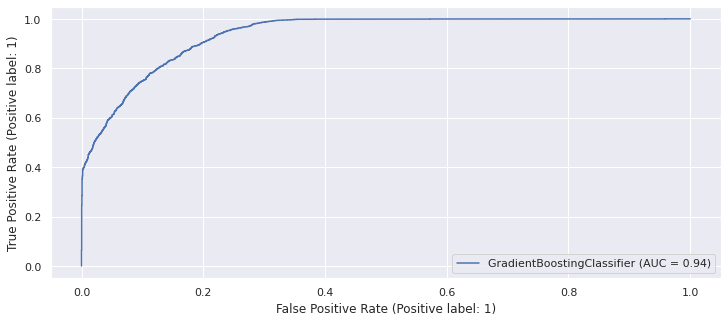

In [149]:
from sklearn import  metrics
metrics.plot_roc_curve(model,X_validation, Y_validation) 
metrics.roc_auc_score(Y_validation, predictions_p[:,1])

<AxesSubplot:xlabel='Predecido', ylabel='Verdadero'>

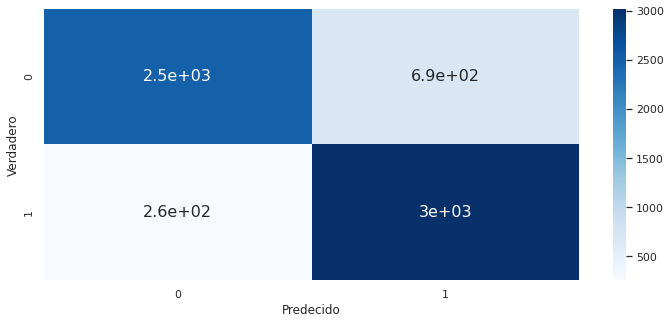

In [151]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), 
                     columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Verdadero'
df_cm.columns.name = 'Predecido'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

### Feature Importance

[3.55487289e-02 1.12332379e-01 7.02464838e-02 7.68481394e-03
 9.90670701e-03 2.67044415e-03 4.17339251e-03 1.99274946e-03
 4.11393495e-03 7.04167988e-01 1.20391847e-02 8.00612284e-03
 5.09298766e-03 5.72453766e-03 5.56340418e-03 4.32621344e-03
 1.26262283e-03 2.14413342e-03 1.26390811e-03 3.64202248e-04
 5.37422633e-04 1.43190537e-04 2.07496865e-04 4.86951260e-04]


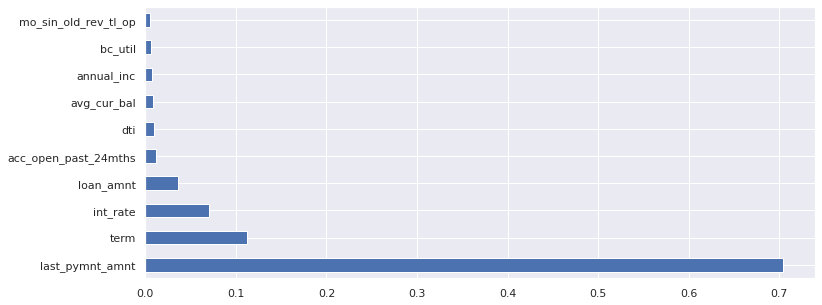

In [152]:
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [153]:
feat_importances

loan_amnt                              0.035549
term                                   0.112332
int_rate                               0.070246
annual_inc                             0.007685
dti                                    0.009907
earliest_cr_line                       0.002670
fico_range_low                         0.004173
open_acc                               0.001993
revol_util                             0.004114
last_pymnt_amnt                        0.704168
acc_open_past_24mths                   0.012039
avg_cur_bal                            0.008006
bc_open_to_buy                         0.005093
bc_util                                0.005725
mo_sin_old_rev_tl_op                   0.005563
mo_sin_rcnt_rev_tl_op                  0.004326
mort_acc                               0.001263
num_actv_rev_tl                        0.002144
home_ownership_RENT                    0.001264
verification_status_Source Verified    0.000364
verification_status_Verified           0